In [ ]:
!pip install BERTopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 4.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from sklearn.feature_extraction.text import CountVectorizer

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/My Drive/Text Analytics project/data_with_extracted_skills_ONET_ESCO.xls")

In [ ]:
df

job_id                                          job_title  \
0      74630583                   Procurement Executive (Contract)   
1      74660602                       Account Executive/ Assistant   
2      74655679       Data Analyst - Asset Management, SPX Express   
3      74657624                                   Service Engineer   
4      74679363                               Purchasing Executive   
...         ...                                                ...   
65309  84013546                        Senior Executive - Accounts   
65310  83966206            Finance Executive (Chinese Female only)   
65311  83634697        Senior Key Account Executive (Retail Sales)   
65312  83991064  ASSISTANT INTERNAL AUDIT MANAGER / SR INTERNAL...   
65313  83822822                        Customer Service Specialist   

                                             company  \
0              Coca-Cola Bottlers (Malaysia) Sdn Bhd   
1                 Acoustic & Lighting System Sdn Bhd   
2                     Shopee Mobile Malaysia Sdn Bhd   
3                        Sun Medical Systems Sdn Bhd   
4             Magnet Security & Automation Sdn. Bhd.   
...                                              ...   
65309                            WCT Holdings Berhad   
65310                       Kota Menara Ufuk Sdn Bhd   
65311  Triumph International Services (APAC) Limited   
65312                         TASEK CONCRETE SDN BHD   
65313                             Private Advertiser   

                                            descriptions            State  \
0      Position Purpose\nManage aspects of procuremen...  Negeri Sembilan   
1      We are looking for a Account Executive/ Assist...         Selangor   
2      Performs detailed data analysis on existing sp...         Selangor   
3      You are important for troubleshooting, install...         Selangor   
4      MAG is a trailblazer in the industry, boasting...         Selangor   
...                                                  ...              ...   
65309  Job Responsibility:\nReview supplier invoices ...         Selangor   
65310  1.    Perform Month End, Year End Close and Re...         Selangor   
65311  Triumph is one of the world’s largest intimate...         Selangor   
65312  JOB FUNCTION:\n1. Perform internal audits to e...         Selangor   
65313  About Us\nAI Elite Mastery Sdn Bhd is a leadin...         Selangor   

                 merged_category                              category  \
0      Manufacturing & Logistics  Manufacturing, Transport & Logistics   
1           Accounting & Finance                            Accounting   
2      Manufacturing & Logistics  Manufacturing, Transport & Logistics   
3       Engineering & Technology                           Engineering   
4      Manufacturing & Logistics  Manufacturing, Transport & Logistics   
...                          ...                                   ...   
65309       Accounting & Finance                            Accounting   
65310       Accounting & Finance                            Accounting   
65311          Sales & Marketing                                 Sales   
65312       Accounting & Finance                            Accounting   
65313             Administration       Administration & Office Support   

                                   subcategory                   role_clean  \
0          Purchasing, Procurement & Inventory        Procurement Executive   
1      Bookkeeping & Small Practice Accounting          Executive Assistant   
2                         Analysis & Reporting     Asset Management Analyst   
3            Electrical/Electronic Engineering            Services Engineer   
4          Purchasing, Procurement & Inventory         Purchasing Executive   
...                                        ...                          ...   
65309  Bookkeeping & Small Practice Accounting           Accounts Executive   
65310  Bookkeeping & Small Practice Accounting   

#Pre-processing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65314 entries, 0 to 65313
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   job_id                 65314 non-null  int64 
 1   job_title              65314 non-null  object
 2   company                65314 non-null  object
 3   descriptions           65314 non-null  object
 4   State                  65314 non-null  object
 5   merged_category        65314 non-null  object
 6   category               65314 non-null  object
 7   subcategory            65314 non-null  object
 8   role_clean             65314 non-null  object
 9   type_clean             65314 non-null  object
 10  salary                 29676 non-null  object
 11  clean_title+desc       65314 non-null  object
 12  extracted_skills_list  65314 non-null  object
dtypes: int64(1), object(12)
memory usage: 6.5+ MB


In [ ]:
# Convert all to string except for extracted_skills_list
for col in df.columns:
    if col != 'extracted_skills_list':
        df[col] = df[col].astype('string')

In [ ]:
# Convert extracted_skills_list to list
import ast
df['extracted_skills_list'] = df['extracted_skills_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65314 entries, 0 to 65313
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   job_id                 65314 non-null  string
 1   job_title              65314 non-null  string
 2   company                65314 non-null  string
 3   descriptions           65314 non-null  string
 4   State                  65314 non-null  string
 5   merged_category        65314 non-null  string
 6   category               65314 non-null  string
 7   subcategory            65314 non-null  string
 8   role_clean             65314 non-null  string
 9   type_clean             65314 non-null  string
 10  salary                 29676 non-null  string
 11  clean_title+desc       65314 non-null  string
 12  extracted_skills_list  65314 non-null  object
dtypes: object(1), string(12)
memory usage: 6.5+ MB


In [ ]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=d5d9f9cccabaec4ca6975aba57f03e843ef1d9eb603f46a17704329d9108fa8d
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [ ]:
# Detect non-English job descriptions

from langdetect import detect

def detect_lang(text):
    try:
        return detect(text)
    except:
        return "unknown"

df["lang"] = df["descriptions"].apply(detect_lang)

In [ ]:
lang_counts = df["lang"].value_counts()
lang_counts

lang
en         64621
id           508
zh-cn        112
de            25
vi            24
ko            10
unknown        2
ja             2
th             2
tl             2
fr             1
es             1
no             1
sk             1
so             1
ca             1
Name: count, dtype: int64

In [ ]:
# Keep only English descriptions
df = df[df["lang"] == "en"].copy()

In [ ]:
lang_counts = df["lang"].value_counts()
lang_counts

lang
en    64621
Name: count, dtype: int64

In [ ]:
# Tag skills in the text for later analysis
def tag_skills(text, skills):
    if not isinstance(skills, list) or len(skills) == 0:
        return text

    tagged_text = text
    for skill in skills:
        skill = skill.strip()
        if not skill:
            continue

        pattern = rf"(?i)(?<!\w){re.escape(skill)}(?!\w)"
        tagged_text = re.sub(pattern, r"<skill> \g<0> </skill>", tagged_text)
    return tagged_text


In [ ]:
def clean_text(text):
    text = re.sub(r'<.*?>', ' ', text)  # remove HTML
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)  # remove URLs
    text = re.sub(r'\s+', ' ', text)  # normalize spaces
    return text.strip()

In [ ]:
df["cleaned_desc"] = df["descriptions"].apply(clean_text)
df = df[df["cleaned_desc"].str.len() > 50]
print(f"After cleaning: {df.shape}")

After cleaning: (64601, 15)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64601 entries, 0 to 65313
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   job_id                 64601 non-null  string
 1   job_title              64601 non-null  string
 2   company                64601 non-null  string
 3   descriptions           64601 non-null  string
 4   State                  64601 non-null  string
 5   merged_category        64601 non-null  string
 6   category               64601 non-null  string
 7   subcategory            64601 non-null  string
 8   role_clean             64601 non-null  string
 9   type_clean             64601 non-null  string
 10  salary                 29349 non-null  string
 11  clean_title+desc       64601 non-null  string
 12  extracted_skills_list  64601 non-null  object
 13  lang                   64601 non-null  object
 14  cleaned_desc           64601 non-null  object
dtypes: object(3), string(12)

In [ ]:
for col in df.columns:
    if col != 'extracted_skills_list':
        df[col] = df[col].astype('string')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64601 entries, 0 to 65313
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   job_id                 64601 non-null  string
 1   job_title              64601 non-null  string
 2   company                64601 non-null  string
 3   descriptions           64601 non-null  string
 4   State                  64601 non-null  string
 5   merged_category        64601 non-null  string
 6   category               64601 non-null  string
 7   subcategory            64601 non-null  string
 8   role_clean             64601 non-null  string
 9   type_clean             64601 non-null  string
 10  salary                 29349 non-null  string
 11  clean_title+desc       64601 non-null  string
 12  extracted_skills_list  64601 non-null  object
 13  lang                   64601 non-null  string
 14  cleaned_desc           64601 non-null  string
dtypes: object(1), string(14)

In [ ]:
df["tagged_text"] = df.apply(lambda r: tag_skills(str(r["cleaned_desc"]), r["extracted_skills_list"]), axis=1)

In [ ]:
# Confirm that skills have been tagged as intended
df['tagged_text'].iloc[0]

'Position Purpose Manage aspects of procurement including <skill> supplier management </skill>, <skill> contract management </skill>, and vendor performance tracking. Support the administration and management of procurement <skill> processes </skill>. This includes setting up, maintaining, and administering purchasing databases; developing and <skill> issuing purchase orders </skill>; maintain contract log and providing support to other departments within the organization who are involved in procurement. Key Duties / Responsibilities General Ensure the PO created following the bidding requirements OA updates from time to time - upon request from planning team / buyers Geographical coverage: Malaysia and Singapore operations Ensure all purchasing activities comply with Procurement Procedure and company internal policy Actively seek out opportunities for improvement, ways to do things better; and <skill> lead </skill> implementation of actions defined Manage reports and reviews Manage re

In [ ]:
df

job_id                                          job_title  \
0      74630583                   Procurement Executive (Contract)   
1      74660602                       Account Executive/ Assistant   
2      74655679       Data Analyst - Asset Management, SPX Express   
3      74657624                                   Service Engineer   
4      74679363                               Purchasing Executive   
...         ...                                                ...   
65309  84013546                        Senior Executive - Accounts   
65310  83966206            Finance Executive (Chinese Female only)   
65311  83634697        Senior Key Account Executive (Retail Sales)   
65312  83991064  ASSISTANT INTERNAL AUDIT MANAGER / SR INTERNAL...   
65313  83822822                        Customer Service Specialist   

                                             company  \
0              Coca-Cola Bottlers (Malaysia) Sdn Bhd   
1                 Acoustic & Lighting System Sdn Bhd   
2                     Shopee Mobile Malaysia Sdn Bhd   
3                        Sun Medical Systems Sdn Bhd   
4             Magnet Security & Automation Sdn. Bhd.   
...                                              ...   
65309                            WCT Holdings Berhad   
65310                       Kota Menara Ufuk Sdn Bhd   
65311  Triumph International Services (APAC) Limited   
65312                         TASEK CONCRETE SDN BHD   
65313                             Private Advertiser   

                                            descriptions            State  \
0      Position Purpose
Manage aspects of procurement...  Negeri Sembilan   
1      We are looking for a Account Executive/ Assist...         Selangor   
2      Performs detailed data analysis on existing sp...         Selangor   
3      You are important for troubleshooting, install...         Selangor   
4      MAG is a trailblazer in the industry, boasting...         Selangor   
...                                                  ...              ...   
65309  Job Responsibility:
Review supplier invoices a...         Selangor   
65310  1.    Perform Month End, Year End Close and Re...         Selangor   
65311  Triumph is one of the world’s largest intimate...         Selangor   
65312  JOB FUNCTION:
1. Perform internal audits to en...         Selangor   
65313  About Us
AI Elite Mastery Sdn Bhd is a leading...         Selangor   

                 merged_category                              category  \
0      Manufacturing & Logistics  Manufacturing, Transport & Logistics   
1           Accounting & Finance                            Accounting   
2      Manufacturing & Logistics  Manufacturing, Transport & Logistics   
3       Engineering & Technology                           Engineering   
4      Manufacturing & Logistics  Manufacturing, Transport & Logistics   
...                          ...                                   ...   
65309       Accounting & Finance                            Accounting   
65310       Accounting & Finance                            Accounting   
65311          Sales & Marketing                                 Sales   
65312       Accounting & Finance                            Accounting   
65313             Administration       Administration & Office Support   

                                   subcategory                   role_clean  \
0          Purchasing, Procurement & Inventory        Procurement Executive   
1      Bookkeeping & Small Practice Accounting          Executive Assistant   
2                         Analysis & Reporting     Asset Management Analyst   
3            Electrical/Electronic Engineering            Services Engineer   
4          Purchasing, Procurement & Inventory         Purchasing Executive   
...                                        ...                          ...   
65309  Bookkeeping & Small Practice Accounting           Accounts Executive   
65310  Bookkeeping & Small Practice Accounting   

In [ ]:
# Count words in tagged_text column
df['word_count'] = df['tagged_text'].apply(lambda x: len(str(x).split()))

print(f"Mean: {df['word_count'].mean():.2f}")
print(f"Median: {df['word_count'].median():.2f}")
print(f"Standard Deviation: {df['word_count'].std():.2f}")
print(f"Min: {df['word_count'].min()}")
print(f"Max: {df['word_count'].max()}")
print(f"Total words: {df['word_count'].sum()}")

print("\nFirst few rows with word counts:")
print(df[['tagged_text', 'word_count']].head())


Mean: 343.02
Median: 274.00
Standard Deviation: 242.13
Min: 8
Max: 2636
Total words: 22159136

First few rows with word counts:
                                         tagged_text  word_count
0  Position Purpose Manage aspects of procurement...         325
1  We are looking for a Account Executive/ Assist...         147
2  Performs detailed <skill> data </skill> analys...         145
3  You are important for <skill> troubleshooting ...         272
4  MAG is a trailblazer in the industry, boasting...         364


In [ ]:
def semantic_chunking(text, max_words=200):
    sentences = sent_tokenize(text)
    chunks, current_chunk, current_len = [], [], 0
    for sent in sentences:
        words = sent.split()
        if current_len + len(words) > max_words and current_chunk:
            chunks.append(" ".join(current_chunk))
            current_chunk, current_len = [], 0
        current_chunk.append(sent)
        current_len += len(words)
    if current_chunk:
        chunks.append(" ".join(current_chunk))
    return chunks

In [ ]:
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt_tab')
chunked_data = []
for idx, row in df.iterrows():
    text = row["tagged_text"]
    chunks = semantic_chunking(text, max_words=200)
    if not chunks:
        continue
    for chunk in chunks:
        chunked_data.append({
            "job_id": row["job_id"],
            "merged_category": row["merged_category"],
            "chunk_text": chunk,
            "extracted_skills_list": row["extracted_skills_list"]
        })

chunked_df = pd.DataFrame(chunked_data)
print(f"Semantic chunking complete — {len(chunked_df)} chunks from {len(df)} jobs.")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Semantic chunking complete — 146894 chunks from 64601 jobs.


In [ ]:
chunked_df

job_id            merged_category  \
0       74630583  Manufacturing & Logistics   
1       74630583  Manufacturing & Logistics   
2       74660602       Accounting & Finance   
3       74655679  Manufacturing & Logistics   
4       74657624   Engineering & Technology   
...          ...                        ...   
146889  83991064       Accounting & Finance   
146890  83822822             Administration   
146891  83822822             Administration   
146892  83822822             Administration   
146893  83822822             Administration   

                                               chunk_text  \
0       Position Purpose Manage aspects of procurement...   
1       Vendor Creation follows the policy and acknowl...   
2       We are looking for a Account Executive/ Assist...   
3       Performs detailed <skill> data </skill> analys...   
4       You are important for <skill> troubleshooting ...   
...                                                   ...   
146889  Learn how to protect yourself <skill> Report <...   
146890  About Us AI Elite Mastery Sdn Bhd is a leading...   
146891  Key Responsibilities Audience Engagement and A...   
146892  Familiarity with payment processing systems an...   
146893  Register Sign In Employer questions Your appli...   

                                    extracted_skills_list  
0       [business laws, contract management, english, ...  
1       [business laws, contract management, english, ...  
2                                      [balance, banking]  
3           [asset management, data, data analysis, plan]  
4       [argument, biomedical engineering, cardiology,...  
...                                                   ...  
146889  [control system, internal audits, lead, plan, ...  
146890  [access, communication, coordination, crm, cur...  
146891  [access, communication, coordination, crm, cur...  
146892  [access, communication, coordination, crm, cur...  
146893  [access, communication, coordination, crm, cur...  

[146894 rows x 4 columns]

# Training

In [ ]:
jobbert_model = SentenceTransformer("TechWolf/JobBERT-v2")
representation_model = KeyBERTInspired()

modules.json:   0%|          | 0.00/339 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

2_Asym/140216480444672_Dense/model.safet(…):   0%|          | 0.00/3.15M [00:00<?, ?B/s]

2_Asym/140216480445248_Dense/model.safet(…):   0%|          | 0.00/3.15M [00:00<?, ?B/s]

In [ ]:
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")

In [ ]:
def weighted_embeddings(docs, skill_lists, model, alpha=0.7):
    doc_embeds = model.encode(docs)
    weighted = []
    for doc_emb, skills in zip(doc_embeds, skill_lists):
        if not skills:
            weighted.append(doc_emb)
            continue
        skill_embeds = model.encode(skills)
        final_emb = alpha * doc_emb + (1 - alpha) * np.mean(skill_embeds, axis=0)
        weighted.append(final_emb)
    return np.vstack(weighted)


In [ ]:
categories = chunked_df["merged_category"].unique()
category_models = {}
category_results = {}
category_docs = {}

for cat in sorted(categories):
    subset = chunked_df[chunked_df["merged_category"] == cat].copy()
    subset = subset[subset["chunk_text"].str.split().str.len() >= 20]
    docs = subset["chunk_text"].tolist()

    if len(docs) < 10:
        print(f"Skipping {cat} — too few chunks ({len(docs)})")
        continue

    category_docs[cat] = docs

    print(f"\n Training category: {cat} (n={len(docs)})")

    # Compute embeddings
    embeddings = weighted_embeddings(docs, subset["extracted_skills_list"], jobbert_model)
    topic_model = BERTopic(
        embedding_model=jobbert_model,
        representation_model=representation_model,
        vectorizer_model=vectorizer_model,
        nr_topics="auto",
        top_n_words=10,
        verbose=True,
    )

    topics, probs = topic_model.fit_transform(docs, embeddings)

    # Store results
    topic_info = topic_model.get_topic_info()
    category_results[cat] = topic_info
    category_models[cat] = topic_model

    # Display Top 10 topics
    print(f"\n{cat} — Top 10 Topics:")
    for i, row in topic_info.head(10).iterrows():
        print(f"  Topic {row['Topic']}: {', '.join(row['Representation'])} (n={row['Count']})")




 Training category: Accounting & Finance (n=27183)


2025-11-01 07:38:59,360 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-01 07:39:07,464 - BERTopic - Dimensionality - Completed ✓
2025-11-01 07:39:07,465 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-01 07:39:09,960 - BERTopic - Cluster - Completed ✓
2025-11-01 07:39:09,961 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-01 07:39:18,187 - BERTopic - Representation - Completed ✓
2025-11-01 07:39:18,206 - BERTopic - Topic reduction - Reducing number of topics
2025-11-01 07:39:18,782 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-01 07:39:42,868 - BERTopic - Representation - Completed ✓
2025-11-01 07:39:42,893 - BERTopic - Topic reduction - Reduced number of topics from 347 to 194



Accounting & Finance — Top 10 Topics:
  Topic -1: accounting, accounting skill, skill accounting, finance, audit, financial, skill financial, bank, reconciliation, accounts (n=11810)
  Topic 0: accounting, accounting skill, skill accounting, reconciliation, payable, cash, finance, accounts, invoices, audit (n=5296)
  Topic 1: cross sell, branch, banking, wealth, banking skill, bank, cross selling, skill banking, sales plans, lending (n=592)
  Topic 2: steel, global, asia, manufacturing, manufacturing skill, international, holdings, worldwide, malaysia, industrial (n=389)
  Topic 3: tax manager, corporate tax, tax computations, income tax, taxation, manage tax, tax computation, review tax, indirect tax, tax authorities (n=353)
  Topic 4: payroll operations, accurate payroll, payroll related, ensure payroll, payroll, payroll information, payroll processing, payroll skill, hr payroll, processing payroll (n=339)
  Topic 5: difference advocate, advocate inclusion, prosperity unique, inclus

2025-11-01 07:42:57,111 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-01 07:43:00,175 - BERTopic - Dimensionality - Completed ✓
2025-11-01 07:43:00,176 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-01 07:43:00,666 - BERTopic - Cluster - Completed ✓
2025-11-01 07:43:00,667 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-01 07:43:04,525 - BERTopic - Representation - Completed ✓
2025-11-01 07:43:04,537 - BERTopic - Topic reduction - Reducing number of topics
2025-11-01 07:43:04,634 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-01 07:43:15,911 - BERTopic - Representation - Completed ✓
2025-11-01 07:43:15,924 - BERTopic - Topic reduction - Reduced number of topics from 142 to 98



Administration — Top 10 Topics:
  Topic -1: documents, administration, administrative, admin, salary, apply, communication, candidate, english, english skill (n=4309)
  Topic 0: secretarial, administrative, administrative support, administration, meetings, meeting, assistant, office, correspondence, executive (n=1681)
  Topic 1: fraudulent discrimination, select fraudulent, earn administration, ad fraudulent, fraudulent, discrimination misleading, fraudulent misleading, misleading discriminatory, discrimination, investigation include (n=514)
  Topic 2: skill mandarin, mandarin skill, bahasa malaysia, mandarin, skill chinese, chinese skill, skill malay, malay skill, chinese, skill bahasa (n=314)
  Topic 3: hr, hr policies, hr related, human resource, human resources, payroll, employee records, onboarding, payroll processing, administrative (n=311)
  Topic 4: timber, oil palm, palm plantation, segment involved, segment, steel, palm, industry, company profile, plantation (n=289)
  Topic 

2025-11-01 07:44:59,914 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-01 07:45:02,626 - BERTopic - Dimensionality - Completed ✓
2025-11-01 07:45:02,627 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-01 07:45:02,827 - BERTopic - Cluster - Completed ✓
2025-11-01 07:45:02,828 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-01 07:45:04,896 - BERTopic - Representation - Completed ✓
2025-11-01 07:45:04,902 - BERTopic - Topic reduction - Reducing number of topics
2025-11-01 07:45:04,968 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-01 07:45:11,381 - BERTopic - Representation - Completed ✓
2025-11-01 07:45:11,388 - BERTopic - Topic reduction - Reduced number of topics from 113 to 61



Construction & Trades — Top 10 Topics:
  Topic -1: construction, salary, job ad, provide, management skill, fraudulent, able, skill construction, contractors, control (n=1852)
  Topic 0: quantity surveyor, contract administration, cost control, costing, estimates, estimation, procurement, quotation, contracts, quantity surveying (n=518)
  Topic 1: tenants, lease, maintenance skill, tenant, leasing skill, property management, leasing, tenancy, building, air conditioning (n=518)
  Topic 2: project manager, civil, construction management, skill civil, project management, construction, project skill, completion, engineering, engineering skill (n=517)
  Topic 3: fraudulent discrimination, select fraudulent, ad fraudulent, fraudulent, fraudulent misleading, misleading discriminatory, discrimination, discrimination misleading, bank credit, advert careful (n=314)
  Topic 4: real estate, property development, property developers, investment, malaysia, property, properties, portfolio, estate in

2025-11-01 07:45:58,362 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-01 07:46:15,094 - BERTopic - Dimensionality - Completed ✓
2025-11-01 07:46:15,095 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-01 07:46:15,173 - BERTopic - Cluster - Completed ✓
2025-11-01 07:46:15,174 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-01 07:46:16,071 - BERTopic - Representation - Completed ✓
2025-11-01 07:46:16,073 - BERTopic - Topic reduction - Reducing number of topics
2025-11-01 07:46:16,086 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-01 07:46:18,693 - BERTopic - Representation - Completed ✓
2025-11-01 07:46:18,700 - BERTopic - Topic reduction - Reduced number of topics from 33 to 22



Creative & Design — Top 10 Topics:
  Topic -1: creative, graphic, graphic skill, designer, illustrator, photoshop, advertising, editing, content, design (n=435)
  Topic 0: autocad, designer, architectural, architect, design, architecture, designs, interior, design skill, interior skill (n=748)
  Topic 1: adobe creative, ui ux, ux, designer, illustrator, graphic, creative, photoshop, ui, graphic skill (n=450)
  Topic 2: video editor, videographer, video editing, video content, video production, video skill, adobe premiere, video, videography, skill video (n=171)
  Topic 3: diversity, experience, diverse, talent, industry, growth, global, culture, positive, innovation (n=168)
  Topic 4: graphic designer, earn graphic, ad fraudulent, fraudulent discrimination, graphic, select fraudulent, designer, advert careful, fraudulent, ad email (n=166)
  Topic 5: programmatic, digital media, media planning, ads, campaigns, media, account management, creative, marketing advertising, agency (n=65)
  

2025-11-01 07:46:56,904 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-01 07:47:05,482 - BERTopic - Dimensionality - Completed ✓
2025-11-01 07:47:05,483 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-01 07:47:05,557 - BERTopic - Cluster - Completed ✓
2025-11-01 07:47:05,558 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-01 07:47:06,300 - BERTopic - Representation - Completed ✓
2025-11-01 07:47:06,302 - BERTopic - Topic reduction - Reducing number of topics
2025-11-01 07:47:06,323 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-01 07:47:08,480 - BERTopic - Representation - Completed ✓
2025-11-01 07:47:08,485 - BERTopic - Topic reduction - Reduced number of topics from 57 to 20



Education — Top 10 Topics:
  Topic -1: curriculum, international school, language skill, language, secondary, schools, teaching, education, english, teachers (n=547)
  Topic 0: curriculum, academic, degree, teach, education, teaching, university, educational, teachers, diploma (n=991)
  Topic 1: fraudulent discrimination, select fraudulent, discrimination misleading, discrimination, fraudulent, researching careers, ad fraudulent, fraudulent misleading, misleading discriminatory, salary information (n=192)
  Topic 2: prospective students, student recruitment, students parents, enrolment, admissions, study abroad, education fairs, recruitment activities, admission, university (n=58)
  Topic 3: project manager, project management, stakeholder, stakeholders, initiatives, budgets, program, programs, budget, coordination (n=40)
  Topic 4: training initiatives, initiatives projects, initiatives, updated programs, strategies, technology practices, programs, learning, solutions, effectiveness 

2025-11-01 07:58:58,736 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-01 07:59:09,912 - BERTopic - Dimensionality - Completed ✓
2025-11-01 07:59:09,913 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-01 07:59:13,326 - BERTopic - Cluster - Completed ✓
2025-11-01 07:59:13,327 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-01 07:59:26,840 - BERTopic - Representation - Completed ✓
2025-11-01 07:59:26,874 - BERTopic - Topic reduction - Reducing number of topics
2025-11-01 07:59:28,102 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-01 08:00:18,461 - BERTopic - Representation - Completed ✓
2025-11-01 08:00:18,499 - BERTopic - Topic reduction - Reduced number of topics from 528 to 350



Engineering & Technology — Top 10 Topics:
  Topic -1: skill engineering, skill security, industry, report, security skill, report skill, skill design, design skill, application, software (n=16279)
  Topic 0: software development, asp net, developer, devops skill, devops, skill devops, developers, software, java, skill javascript (n=1997)
  Topic 1: civil engineering, project manager, civil, skill civil, project management, autocad, construction, subcontractors, engineering skill, engineering (n=1136)
  Topic 2: fraudulent discrimination, select fraudulent, fraudulent, discrimination misleading, ad fraudulent, discrimination, salary insights, fraudulent misleading, misleading discriminatory, researching careers (n=984)
  Topic 3: network infrastructure, cisco, cisco skill, skill cisco, firewalls, active directory, networking, lan, information technology, firewall (n=913)
  Topic 4: skill scada, scada, plc skill, plc, skill electrical, skill plc, control systems, electrical skill, elect

2025-11-01 08:00:56,515 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-01 08:01:04,262 - BERTopic - Dimensionality - Completed ✓
2025-11-01 08:01:04,263 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-01 08:01:04,322 - BERTopic - Cluster - Completed ✓
2025-11-01 08:01:04,323 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-01 08:01:05,089 - BERTopic - Representation - Completed ✓
2025-11-01 08:01:05,091 - BERTopic - Topic reduction - Reducing number of topics
2025-11-01 08:01:05,106 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-01 08:01:07,037 - BERTopic - Representation - Completed ✓
2025-11-01 08:01:07,042 - BERTopic - Topic reduction - Reduced number of topics from 41 to 17



Healthcare — Top 10 Topics:
  Topic -1: fraudulent, provide, job ad, job advert, salary, related, application, english skill, profile, skill english (n=279)
  Topic 0: fraudulent, apply, job ad, salary, investigation, provide, nurse, related, benefits, nursing (n=1123)
  Topic 1: pharmacist, pharmacists, pharmacy skill, pharmacy, registered pharmacist, degree pharmacy, medicines skill, pharmaceutical, prescription, skill medicines (n=123)
  Topic 2: dietetics skill, nutritionist, nutritional skill, dietetics, provide nutritional, skill dietetics, nutrition skill, nutritional, wellness, nutrition (n=82)
  Topic 3: regulatory affairs, regulatory, regulatory authorities, regulatory requirements, skill regulatory, product registration, experience regulatory, pharmacovigilance, regulations, validation (n=75)
  Topic 4: aesthetic doctor, medical aesthetic, aesthetic doctors, aesthetic wellness, aesthetic services, aesthetic procedures, aesthetic treatments, aesthetic, skin aesthetic, aesthe

2025-11-01 08:03:50,452 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-01 08:03:54,338 - BERTopic - Dimensionality - Completed ✓
2025-11-01 08:03:54,339 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-01 08:03:54,698 - BERTopic - Cluster - Completed ✓
2025-11-01 08:03:54,699 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-01 08:03:57,926 - BERTopic - Representation - Completed ✓
2025-11-01 08:03:57,935 - BERTopic - Topic reduction - Reducing number of topics
2025-11-01 08:03:58,110 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-01 08:04:08,707 - BERTopic - Representation - Completed ✓
2025-11-01 08:04:08,718 - BERTopic - Topic reduction - Reduced number of topics from 189 to 97



Hospitality & Services — Top 10 Topics:
  Topic -1: apply, job ad, provide, fraudulent, skill english, management, malaysia, salary, english, learn (n=2530)
  Topic 0: fraudulent discrimination, select fraudulent, fraudulent, ad fraudulent, fraudulent misleading, misleading discriminatory, discrimination misleading, discrimination, investigation include, investigation (n=3579)
  Topic 1: store manager, retail management, manager, sales targets, store operations, managing, management skill, manage, inventory, store (n=310)
  Topic 2: chef skill, chef, skill chef, chefs, kitchen staff, kitchen team, kitchen, preparation cooking, culinary, cooking (n=261)
  Topic 3: boutique, jewelry, beauty, jewellery, targets, swatch group, sales associate, retail sales, brand, experience retail (n=215)
  Topic 4: retail consumer, outlets, retail, senheng, consumer, customers, best, reviews retail, consumer products, map (n=146)
  Topic 5: barista, beverages skill, beverage outlet, tea, drinks, beverag

2025-11-01 08:06:30,138 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-01 08:06:33,699 - BERTopic - Dimensionality - Completed ✓
2025-11-01 08:06:33,700 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-01 08:06:34,028 - BERTopic - Cluster - Completed ✓
2025-11-01 08:06:34,029 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-01 08:06:37,079 - BERTopic - Representation - Completed ✓
2025-11-01 08:06:37,087 - BERTopic - Topic reduction - Reducing number of topics
2025-11-01 08:06:37,152 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-01 08:06:44,649 - BERTopic - Representation - Completed ✓
2025-11-01 08:06:44,659 - BERTopic - Topic reduction - Reduced number of topics from 110 to 62



Human Resources — Top 10 Topics:
  Topic -1: hr, human resource, human resources, payroll, resource, benefits, recruitment, human, resources, administrative (n=3070)
  Topic 0: hr policies, hr, human resource, human resources, employee relations, employee engagement, payroll, people, onboarding, talent (n=1586)
  Topic 1: recruiter, talent acquisition, recruitment strategies, hiring managers, recruitment, recruiting, sourcing, recruitment process, candidates, talent (n=980)
  Topic 2: fraudulent discrimination, discrimination misleading, discrimination, misleading discriminatory, select fraudulent, ad fraudulent, fraudulent, discriminatory, investigation include, investigation (n=256)
  Topic 3: cx, customer experience, commerce, global, digital, experience, sense belonging, asia, tdcx, growth (n=227)
  Topic 4: human resource, human resources, hr, work malaysia, match job, employment, employer questions, bahasa malaysia, candidates, skills match (n=154)
  Topic 5: occupational safety

2025-11-01 08:06:58,399 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-01 08:06:59,958 - BERTopic - Dimensionality - Completed ✓
2025-11-01 08:06:59,959 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-01 08:06:59,985 - BERTopic - Cluster - Completed ✓
2025-11-01 08:06:59,985 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-01 08:07:00,320 - BERTopic - Representation - Completed ✓
2025-11-01 08:07:00,321 - BERTopic - Topic reduction - Reducing number of topics
2025-11-01 08:07:00,329 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-01 08:07:01,139 - BERTopic - Representation - Completed ✓
2025-11-01 08:07:01,142 - BERTopic - Topic reduction - Reduced number of topics from 17 to 6



Legal & Compliance — Top 10 Topics:
  Topic -1: risk, immigration, language, skill communication, english, communication skill, management skill, policies skill, global, language skill (n=79)
  Topic 0: law, legal, agreements, skill legal, litigation, laws, contracts, legal documents, agreement, laws regulations (n=485)
  Topic 1: fraudulent discrimination, select fraudulent, fraudulent, ad fraudulent, discrimination misleading, fraudulent misleading, discrimination, misleading discriminatory, investigation include, bank credit (n=146)
  Topic 2: trademarks, trademarks skill, skill trademarks, intellectual property, trademark, trademark registration, patent, patent skill, ip, property ip (n=27)
  Topic 3: forensic services, investigations, forensic investigations, investigation, corruption, forensic, investigation papers, deloitte, suspect, relevant laws (n=20)
  Topic 4: wills trust, trusts executor, trust estate, trusts succession, estate planning, related wills, trusts, executor ad

2025-11-01 08:07:20,809 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-01 08:07:23,938 - BERTopic - Dimensionality - Completed ✓
2025-11-01 08:07:23,939 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-01 08:07:23,975 - BERTopic - Cluster - Completed ✓
2025-11-01 08:07:23,976 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-01 08:07:24,446 - BERTopic - Representation - Completed ✓
2025-11-01 08:07:24,448 - BERTopic - Topic reduction - Reducing number of topics
2025-11-01 08:07:24,458 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-01 08:07:25,901 - BERTopic - Representation - Completed ✓
2025-11-01 08:07:25,905 - BERTopic - Topic reduction - Reduced number of topics from 25 to 14



Management & Strategy — Top 10 Topics:
  Topic -1: strategy, initiatives, project management, global, stakeholders, insights, strategic, solutions, business, malaysia (n=286)
  Topic 0: fraudulent, finance, financial, manager, career advice, salary, strategy, seek, job ad, business (n=439)
  Topic 1: sustainability skill, sustainability, esg, skill sustainability, climate change, esg skill, sustainable, climate, environmental social, skill esg (n=94)
  Topic 2: pmo, project management, stakeholders, initiatives, change management, programme, continuous improvement, progress, pm, projects (n=68)
  Topic 3: stakeholders, governance, risk management, skill risk, risk, iso, business continuity, aml, risks, regulatory skill (n=61)
  Topic 4: corporate finance, financial modelling, financial analysis, corporate development, diligence, advisory, investment, analysis, valuation, economic (n=41)
  Topic 5: supply chain, skill manufacturing, manufacturing, chain management, procurement, logisti

2025-11-01 08:10:45,241 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-01 08:10:48,059 - BERTopic - Dimensionality - Completed ✓
2025-11-01 08:10:48,061 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-01 08:10:48,522 - BERTopic - Cluster - Completed ✓
2025-11-01 08:10:48,523 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-01 08:10:52,545 - BERTopic - Representation - Completed ✓
2025-11-01 08:10:52,556 - BERTopic - Topic reduction - Reducing number of topics
2025-11-01 08:10:52,658 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-01 08:11:03,922 - BERTopic - Representation - Completed ✓
2025-11-01 08:11:03,936 - BERTopic - Topic reduction - Reduced number of topics from 146 to 99



Manufacturing & Logistics — Top 10 Topics:
  Topic -1: sourcing, operations, supplier, procurement, manage, communication, management skill, supply chain, skills, logistics skill (n=4487)
  Topic 0: procurement, purchasing, purchase, supplier, purchase skill, supply chain, suppliers, sourcing, contracts, skill purchase (n=1042)
  Topic 1: qc, qa qc, quality management, product quality, quality assurance, quality standards, quality, qa, quality issues, quality control (n=1018)
  Topic 2: manufacturing skill, continuous improvement, skill manufacturing, manufacturing, production skill, ensure production, processes skill, plant, management, skill lead (n=753)
  Topic 3: fraudulent discrimination, select fraudulent, fraudulent, ad fraudulent, discrimination, fraudulent misleading, discrimination misleading, misleading discriminatory, bank credit, credit (n=749)
  Topic 4: warehouse skill, warehouse, skill warehouse, inventory skill, forklift, forklift skill, picking, inventory, shipping, 

2025-11-01 08:16:13,162 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-01 08:16:17,644 - BERTopic - Dimensionality - Completed ✓
2025-11-01 08:16:17,645 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-01 08:16:19,708 - BERTopic - Cluster - Completed ✓
2025-11-01 08:16:19,709 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-01 08:16:25,891 - BERTopic - Representation - Completed ✓
2025-11-01 08:16:25,906 - BERTopic - Topic reduction - Reducing number of topics
2025-11-01 08:16:26,193 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-01 08:16:45,336 - BERTopic - Representation - Completed ✓
2025-11-01 08:16:45,354 - BERTopic - Topic reduction - Reduced number of topics from 250 to 169



Sales & Marketing — Top 10 Topics:
  Topic -1: profile, skill sales, apply, relationships, english, related, communication, account, salary, marketing (n=7357)
  Topic 0: earn sales, fraudulent discrimination, select fraudulent, fraudulent, ad fraudulent, fraudulent misleading, bank credit, discrimination, provide bank, discrimination misleading (n=941)
  Topic 1: marketing strategies, digital marketing, marketing campaigns, marketing plans, degree marketing, marketing team, marketing, marketing activities, branding, campaigns (n=885)
  Topic 2: sales orders, quotation, quotations, sales support, sales order, order processing, customer service, support sales, orders, invoice (n=502)
  Topic 3: bahasa malaysia, skill mandarin, mandarin skill, mandarin speaking, mandarin, skill bahasa, skill sales, bahasa, malaysia, language skill (n=501)
  Topic 4: digital marketing, google ads, seo, seo skill, email marketing, facebook ads, digital, ads, campaigns, marketing campaigns (n=473)
  Topic 

2025-11-01 08:17:06,674 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-01 08:17:09,580 - BERTopic - Dimensionality - Completed ✓
2025-11-01 08:17:09,581 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-01 08:17:09,614 - BERTopic - Cluster - Completed ✓
2025-11-01 08:17:09,614 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-01 08:17:10,078 - BERTopic - Representation - Completed ✓
2025-11-01 08:17:10,080 - BERTopic - Topic reduction - Reducing number of topics
2025-11-01 08:17:10,089 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-01 08:17:12,088 - BERTopic - Representation - Completed ✓
2025-11-01 08:17:12,091 - BERTopic - Topic reduction - Reduced number of topics from 25 to 25



Social & Community / Other — Top 10 Topics:
  Topic -1: claims, claim, insurance, reporting skill, skill reporting, international, skill data, data skill, data, report skill (n=175)
  Topic 0: oil palm, skill agronomy, agronomy skill, agronomy, agricultural, plantation, agriculture, farming, crop, farm (n=124)
  Topic 1: leong financial, life insurance, pacific insurance, financial group, general insurance, investment, insurance berhad, insurance business, prudential, financial (n=106)
  Topic 2: governance, risk management, stakeholders, project management, skill risk, regulatory, risk, risks, initiatives, competencies (n=105)
  Topic 3: fraudulent discrimination, select fraudulent, discrimination misleading, ad fraudulent, discrimination, fraudulent, misleading discriminatory, fraudulent misleading, researching careers, bank credit (n=64)
  Topic 4: actuarial, actuarial science, skill actuarial, reinsurance skill, reinsurance, skill reinsurance, risk, modelling, general insurance, p

In [ ]:
all_topics_df = []
for cat, info in category_results.items():
    df_tmp = info[info["Topic"] != -1].copy()
    df_tmp["category"] = cat
    all_topics_df.append(df_tmp)

all_topics_df = pd.concat(all_topics_df, ignore_index=True)
print("\n Combined topics dataframe:", all_topics_df.shape)


 Combined topics dataframe: (1220, 6)


# Evaluation

In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 92.5 MB/s eta 0:00:00


In [ ]:
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Topic coherence
def calculate_topic_coherence(docs, topics_words, coherence_type='c_v'):
    # Filter out empty topics
    topics_words = [topic for topic in topics_words if len(topic) > 0]

    if len(topics_words) == 0:
        return None

    # Tokenize documents if they're strings
    if isinstance(docs[0], str):
        tokenized_docs = [doc.lower().split() for doc in docs]
    else:
        tokenized_docs = docs

    # Filter out empty documents
    tokenized_docs = [doc for doc in tokenized_docs if len(doc) > 0]

    if len(tokenized_docs) == 0:
        return None

    # Create dictionary
    dictionary = Dictionary(tokenized_docs)

    # Filter topics to only include words in dictionary
    filtered_topics = []
    for topic in topics_words:
        filtered_topic = [word for word in topic if word in dictionary.token2id]
        if len(filtered_topic) >= 2:  # Need at least 2 words for coherence
            filtered_topics.append(filtered_topic)

    if len(filtered_topics) == 0:
        return None

    # Create corpus
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

    try:
        # Calculate coherence
        coherence_model = CoherenceModel(
            topics=filtered_topics,
            texts=tokenized_docs,
            corpus=corpus,
            dictionary=dictionary,
            coherence=coherence_type
        )

        score = coherence_model.get_coherence()

        # Check for NaN or infinite values
        if np.isnan(score) or np.isinf(score):
            return None

        return score
    except Exception as e:
        print(f"    Coherence calculation error ({coherence_type}): {str(e)[:100]}")
        return None

In [ ]:
# Topic diversity
def calculate_topic_diversity(topics_words):
    unique_words = set()
    total_words = 0

    for topic in topics_words:
        unique_words.update(topic)
        total_words += len(topic)

    if total_words == 0:
        return 0.0

    return len(unique_words) / total_words

In [ ]:
def evaluate_category_topics(category, topic_model, docs, top_n_words=10):
    # Get topic info
    topic_info = topic_model.get_topic_info()
    topic_info = topic_info[topic_info["Topic"] != -1]  # Exclude outliers

    if len(topic_info) == 0:
        return {
            "category": category,
            "n_topics": 0,
            "n_docs": len(docs),
            "coherence_cv": None,
            "diversity": None
        }

    # Extract top words for each topic
    topics_words = []
    for topic_id in topic_info["Topic"].values:
        topic = topic_model.get_topic(topic_id)
        if topic and len(topic) > 0:
            words = [word for word, _ in topic[:top_n_words]]
            topics_words.append(words)

    # Calculate diversity first
    diversity = calculate_topic_diversity(topics_words)

    # Calculate coherence metrics
    coherence_cv = calculate_topic_coherence(docs, topics_words, 'c_v')


    return {
        "category": category,
        "n_topics": len(topic_info),
        "n_docs": len(docs),
        "coherence_cv": coherence_cv,
        "diversity": diversity
    }


In [ ]:
evaluation_results = []

for cat in sorted(categories):
    if cat not in category_models:
        print(f"\nSkipping {cat} - no model available")
        continue

    print(f"\nEvaluating category: {cat}")

    topic_model = category_models[cat]
    docs = category_docs[cat]

    results = evaluate_category_topics(cat, topic_model, docs, top_n_words=10)
    evaluation_results.append(results)

    # Print results
    print(f"  Topics: {results['n_topics']}")
    print(f"  Documents: {results['n_docs']}")
    if results['coherence_cv'] is not None:
        print(f"  Coherence (C_V): {results['coherence_cv']:.4f}")
    else:
        print(f"  Coherence (C_V): N/A")
    if results['diversity'] is not None:
        print(f"  Diversity: {results['diversity']:.4f}")
    else:
        print(f"  Diversity: N/A")

# Create results dataframe
evaluation_df = pd.DataFrame(evaluation_results)
print("SUMMARY OF ALL CATEGORIES")
print(evaluation_df.to_string(index=False))



# Calculate overall statistics (excluding None values)
print("OVERALL STATISTICS")
valid_cv = evaluation_df['coherence_cv'].dropna()
valid_diversity = evaluation_df['diversity'].dropna()

if len(valid_cv) > 0:
    print(f"Average Coherence (C_V): {valid_cv.mean():.4f} (n={len(valid_cv)})")
else:
    print("Average Coherence (C_V): N/A")

if len(valid_diversity) > 0:
    print(f"Average Diversity: {valid_diversity.mean():.4f} (n={len(valid_diversity)})")
else:
    print("Average Diversity: N/A")





Evaluating category: Accounting & Finance
  Topics: 193
  Documents: 27183
  Coherence (C_V): 0.7373
  Diversity: 0.8446

Evaluating category: Administration
  Topics: 97
  Documents: 11447
  Coherence (C_V): 0.6786
  Diversity: 0.9041

Evaluating category: Construction & Trades
  Topics: 60
  Documents: 5957
  Coherence (C_V): 0.7233
  Diversity: 0.8950

Evaluating category: Creative & Design
  Topics: 21
  Documents: 2667
  Coherence (C_V): 0.6369
  Diversity: 0.8857

Evaluating category: Education
  Topics: 19
  Documents: 2097
  Coherence (C_V): 0.6790
  Diversity: 0.9211

Evaluating category: Engineering & Technology
  Topics: 349
  Documents: 41057
  Coherence (C_V): 0.7750
  Diversity: 0.8911

Evaluating category: Healthcare
  Topics: 16
  Documents: 1926
  Coherence (C_V): 0.7083
  Diversity: 0.9938

Evaluating category: Hospitality & Services
  Topics: 96
  Documents: 9505
  Coherence (C_V): 0.7308
  Diversity: 0.9437

Evaluating category: Human Resources
  Topics: 61
  Docum

In [ ]:
all_topics_viz = []

for cat in sorted(category_models.keys()):
    model = category_models[cat]
    topic_info = model.get_topic_info()
    topics_filtered = topic_info[topic_info["Topic"] != -1].copy()

    if len(topics_filtered) == 0:
        print(f"No topics found for {cat}")
        continue

    topics_filtered["category"] = cat
    all_topics_viz.append(topics_filtered)

    try:
        print("Visualisation for:", cat)
        fig_topics = model.visualize_topics()
        fig_bar = model.visualize_barchart(top_n_topics=10)
        fig_topics.show()
        fig_bar.show()
    except Exception as e:
        print(f"Visualization error for {cat}: {e}")

all_topics_viz = pd.concat(all_topics_viz, ignore_index=True)
print("\nCombined topics dataframe created:", all_topics_viz.shape)

Visualisation for: Accounting & Finance


Visualisation for: Administration


Visualisation for: Construction & Trades


Visualisation for: Creative & Design


Visualisation for: Education


Visualisation for: Engineering & Technology


Visualisation for: Healthcare


Visualisation for: Hospitality & Services


Visualisation for: Human Resources


Visualisation for: Legal & Compliance


Visualisation for: Management & Strategy


Visualisation for: Manufacturing & Logistics


Visualisation for: Sales & Marketing


Visualisation for: Social & Community / Other



Combined topics dataframe created: (1220, 6)


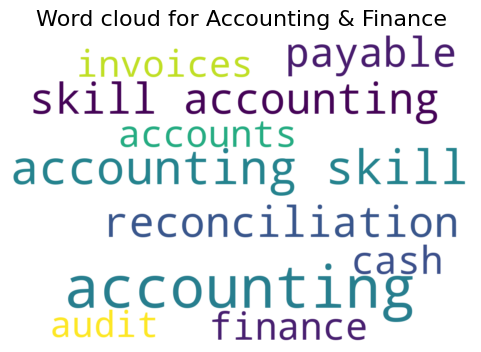

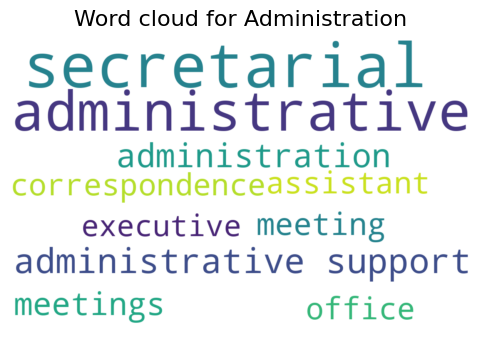

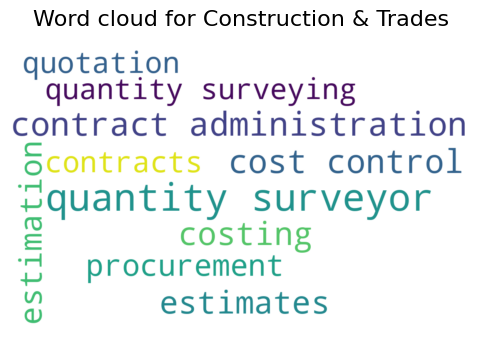

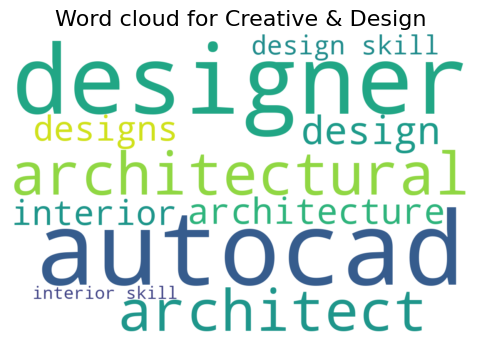

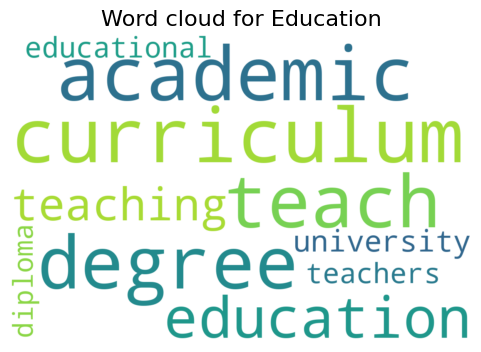

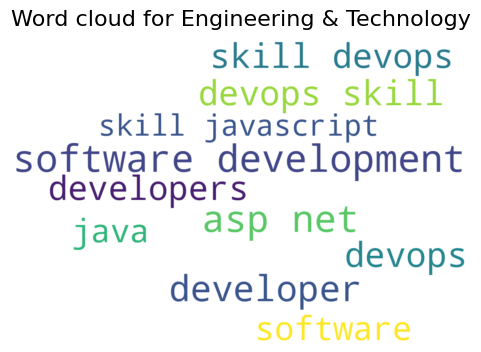

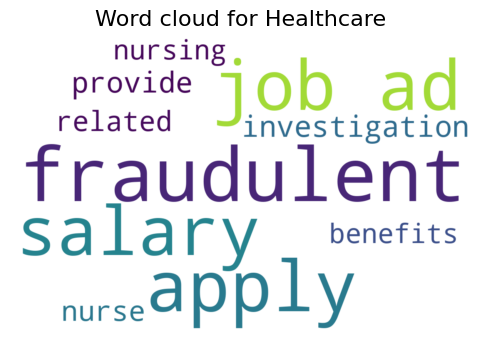

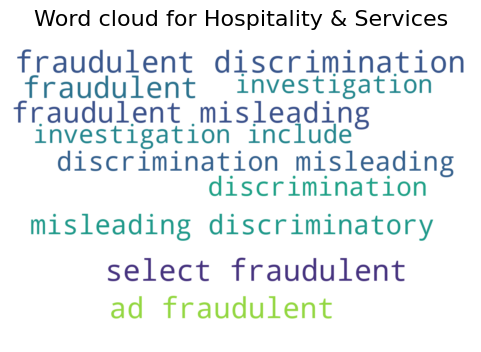

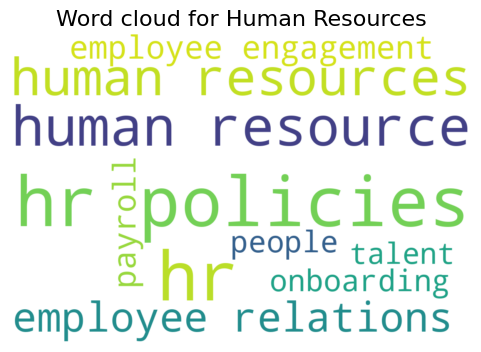

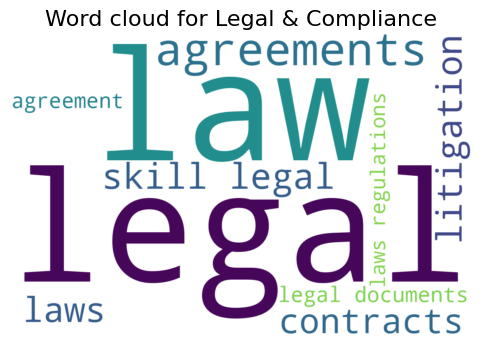

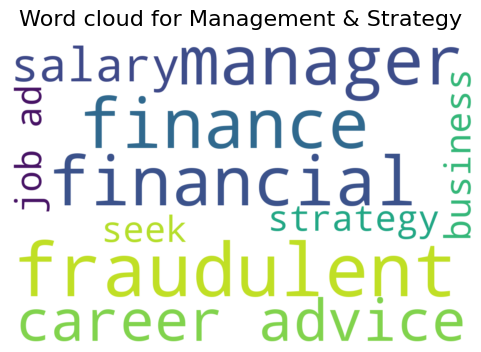

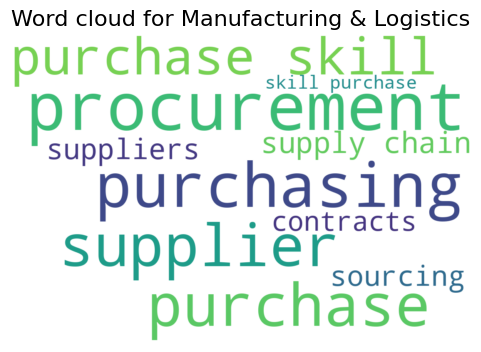

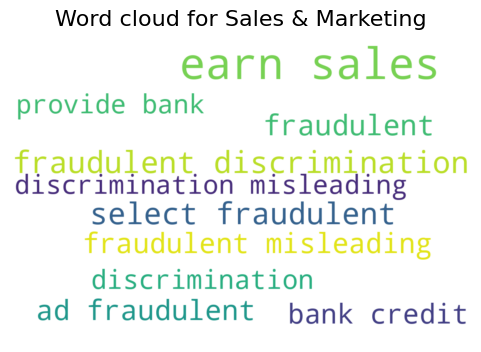

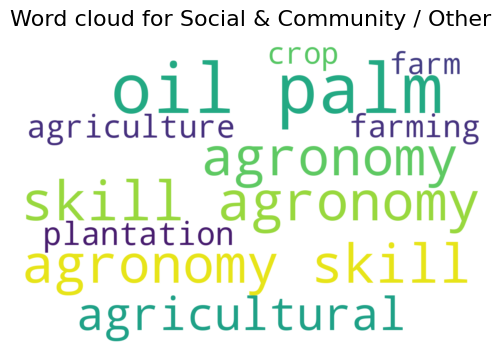

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for cat, model in category_models.items():
    try:
        topic_words = model.get_topic(0)
        if not topic_words:
            print(f"No Topic 0 found for {cat}")
            continue

        # Convert list of tuples into a frequency dictionary
        freqs = dict(topic_words)

        # Create the word cloud
        wordcloud = WordCloud(
            width=1200,
            height=800,
            background_color="white",
            colormap="viridis",
            max_words=200
        ).generate_from_frequencies(freqs)

        # Display
        plt.figure(figsize=(6, 4))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word cloud for {cat}", fontsize=16)
        plt.show()



    except Exception as e:
        print(f"Error generating word cloud for {cat}: {e}")


In [ ]:
all_topics_df.to_csv("bertopic_topic_results_1.csv", index=False)